In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import networkx as nx


from netgraph import Graph, InteractiveGraph

from networkx.algorithms.community import girvan_newman, modularity_max, louvain_communities

from visu_utils import *


In [129]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [130]:
PREFIX = "mteb_ds"
df = pd.read_csv('exported_data/normalized_13.df')
df = text_embeddings_metadata_results_preprocessing(df, short_names=True, models=ALL_MODELS)

METRIC = "I(X_1->X_2)/d_2"


MODELS_OF_INTEREST = GEMMA_MODELS

/home/mdarrin/Documents/phd/transformers/EMIRR/EMIR/nlp_embeddings/analysis/visu_utils.py:55: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  .pivot("model_1", "model_2", metric)
/home/mdarrin/Documents/phd/transformers/EMIRR/EMIR/nlp_embeddings/analysis/visu_utils.py:55: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  .pivot("model_1", "model_2", metric)
/home/mdarrin/Documents/phd/transformers/EMIRR/EMIR/nlp_embeddings/analysis/visu_utils.py:55: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  .pivot("model_1", "model_2", metric)
/home/mdarrin/Documents/phd/transformers/EMIRR/EMIR/nlp_embeddings/analysis/visu_utils.py:55: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  .pivot("model_1", "model_2", metric)


([0, 1, 2, 3],
 [Text(0, 0, 'gemma-2b'),
  Text(1, 0, 'gemma-2b-it'),
  Text(2, 0, 'gemma-7b'),
  Text(3, 0, 'gemma-7b-it')])

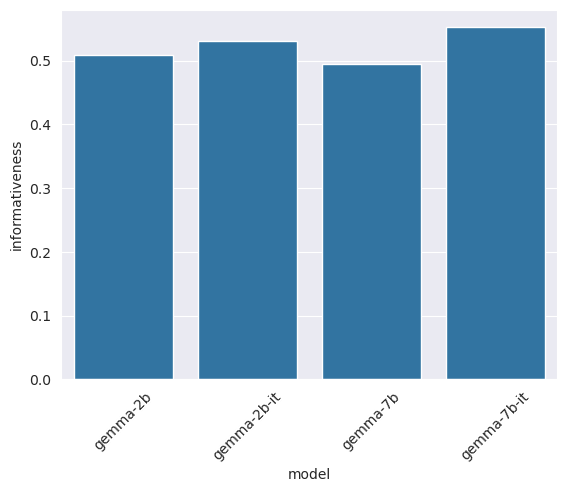

In [131]:


def compute_one_against_all(df, all_models, models, short_names):
    results = []
    for model in models:
        all_models_ = list((set(all_models) - set(models)))
        all_models_.append(model)
                           
        ddf = text_embeddings_metadata_results_preprocessing(df, short_names=True, models=map_short(all_models_))
        table = make_table_pivot(METRIC, ddf)
        
        
        model = map_short([model])[0]
        informativeness = table.median(axis=1).loc[model]
        results.append({'model': model, 'informativeness': informativeness})
            
    return pd.DataFrame(results)


informativeness = compute_one_against_all(df, ALL_MODELS, MODELS_OF_INTEREST, short_names=True)

sns.barplot(data=informativeness, x='model', y='informativeness')
plt.xticks(rotation=45)
            



In [132]:
table = make_table_pivot(METRIC, df) 

/home/mdarrin/Documents/phd/transformers/EMIRR/EMIR/nlp_embeddings/analysis/visu_utils.py:55: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  .pivot("model_1", "model_2", metric)


In [133]:

classifcation_df = pd.read_csv('exported_data/classification_many.csv')

classifcation_df['model'] = classifcation_df['model'].apply(lambda x: eval(x)[0])

rankings = make_rankings_table(classifcation_df, df, METRIC)


/home/mdarrin/Documents/phd/transformers/EMIRR/EMIR/nlp_embeddings/analysis/visu_utils.py:55: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  .pivot("model_1", "model_2", metric)


In [134]:
classifcation_df['rank'] = classifcation_df.groupby('dataset')['success'].rank(ascending=False)

In [168]:


classif = classifcation_df.set_index(['model'])['success'].loc[MODELS_OF_INTEREST]
classif.index = map_short(classif.index)


informativeness_classif = informativeness.set_index('model').merge(classif, left_index=True, right_index=True)


informativeness_classif =informativeness_classif.reset_index().rename(columns={'index': 'model'})
informativeness_classif['informativeness'] = informativeness_classif['informativeness'].apply(lambda x: round(x, 2)).astype(float)

informativeness_classif['Version'] = informativeness_classif['model'].apply(lambda x: "Instruct" if 'it' in x else "Base")
informativeness_classif['Size'] = informativeness_classif['model'].apply(lambda x: x.split('-')[1])

# rename with human names
informativeness_classif = informativeness_classif.rename(columns={'model': 'Model', 'informativeness': 'Informativeness', 'success': 'Classification accuracy'})


/tmp/ipykernel_1090707/4094011265.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_xticklabels(a.get_xticklabels(), rotation=45)
/tmp/ipykernel_1090707/4094011265.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_xticklabels(a.get_xticklabels(), rotation=45)


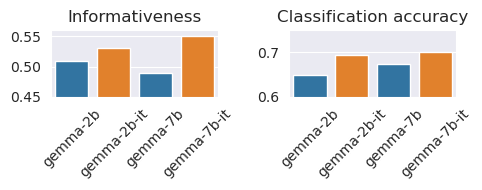

In [181]:
fig, ax = plt.subplots(figsize=(5, 2), ncols=2)
sns.barplot(data=informativeness_classif, x='Model', y='Informativeness', hue='Version', errorbar=None, ax=ax[0])
sns.barplot(data=informativeness_classif, x='Model', y='Classification accuracy', hue='Version', errorbar=None, ax=ax[1])

# make ylims
ax[0].set_ylim(0.45, 0.56)
ax[1].set_ylim(0.6, 0.75)

# remove y labels
ax[0].set_ylabel('')
ax[1].set_ylabel('')

# rotate x labels
for a in ax:
    a.set_xticklabels(a.get_xticklabels(), rotation=45)

ax[0].set_title('Informativeness')
ax[1].set_title('Classification accuracy')

ax[0].set_xlabel('')
ax[1].set_xlabel('')

# remove legend for ax[0]

ax[0].get_legend().remove()
ax[1].get_legend().remove()

fig.tight_layout()

path = Path(f"../../../papers/emir-embedding-comparison/fig/nlp/{PREFIX}_gemma_barplot_instruct_{sanitize_metric_name(METRIC)}.pdf")
path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(path, bbox_inches='tight')



<Axes: xlabel='model', ylabel='success'>

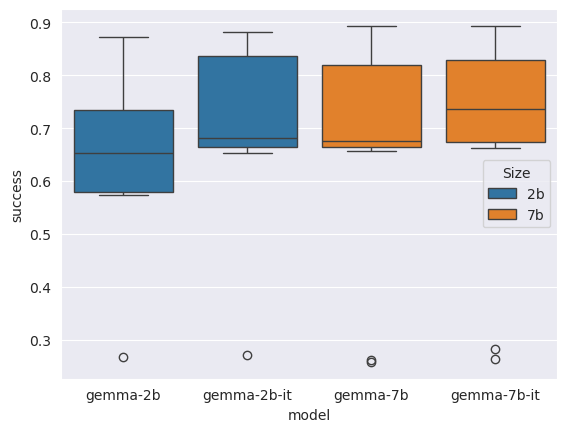